# Evaluate ASR algorithm in motion artifacts removal

In [1]:
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.manifold import TSNE

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
def extract_average_metrics(report):
    average_metrics = report['weighted avg'] 
    return average_metrics['precision'], average_metrics['recall'], average_metrics['f1-score']

def map_labels(y, classes):
    return y.map(classes)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{height:.2f}', ha='center', va='bottom', fontsize=13)

## Preparing Data

### Merge classes

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the directories
dir_names = [
    '1712094934_Nhan', '1712270250_Onila', '1712262127_Brian',
    '1713293584_Jacob', '1713550894_AlexKagoda', '1713820773_Andrew',
    '1713994149_Saad', '1713458084_Andrei', '1714511822_Nathan'
]

# Drop columns that are not needed
drop_columns = ['Index', 'Labels', 'EDA-Skew', 'EDA-Kurt']

# Function to map labels based on the provided order
def map_labels(labels, order):
    return labels.map(order)

# Define the initial empty DataFrame and classes
combined_X = pd.DataFrame()
new_classes = {
    '2 levels': {
        'order': {0: 0, 1: 1},  # Correctly mapping only 2 classes
        'labels': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'Class Metrics': {str(i): {'Precision': [], 'Recall': [], 'F1-Score': []} for i in range(1, 3)}
    }
}

# Read and process the data
for dir_name in dir_names:
    df = pd.read_csv(f'data/logging/{dir_name}/stim_onset_4Hz.csv')
    X_temp = df.drop(drop_columns, axis=1)
    
    for merge in new_classes:
        Y_temp = map_labels(df['Labels'], new_classes[merge]['order'])
        new_classes[merge]['labels'].append(Y_temp)
    
    combined_X = pd.concat([combined_X, X_temp], axis=0, ignore_index=True)

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(combined_X)
combined_X = pd.DataFrame(X_normalized, columns=combined_X.columns)

# Define the groups of features by channels
channels = {
    'O1': [col for col in combined_X.columns if 'O1' in col],
    'O2': [col for col in combined_X.columns if 'O2' in col],
    'C3': [col for col in combined_X.columns if 'C3' in col],
    'C4': [col for col in combined_X.columns if 'C4' in col],
    'EOG': [col for col in combined_X.columns if 'EOG' in col],
    'ECG': ['HR', 'HRV'],
    'EDA': [col for col in combined_X.columns if 'EDA' in col]
}

# Group the features by channels
grouped_features = {channel: combined_X[features] for channel, features in channels.items()}

# Concatenate all labels
labels = pd.concat(new_classes['2 levels']['labels'], axis=0, ignore_index=True)

In [5]:
labels

0       0
1       0
2       0
3       0
4       0
       ..
1069    1
1070    1
1071    1
1072    1
1073    1
Name: Labels, Length: 1074, dtype: int64

In [ ]:
# Prepare base model probabilities
base_model_probabilities = []

# Train base models and gather their predictions
for channel, features in grouped_features.items():
    print(f"Features for channel {channel}:")
    print(features.head())

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train base model
    base_model = RandomForestClassifier(n_estimators=100, random_state=42)
    base_model.fit(X_train, y_train)
    y_prob_test = base_model.predict_proba(X_test)
    
    # Store probabilities for soft voting
    base_model_probabilities.append(y_prob_test)
    
    # Print accuracy and classification report
    y_pred_test = base_model.predict(X_test)
    print(f"Accuracy for {channel}: {accuracy_score(y_test, y_pred_test)}")
    print(classification_report(y_test, y_pred_test))
    
    # Calculate and plot normalized confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
    plt.title(f'Normalized Confusion Matrix for {channel}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Prepare data for soft voting
prob_test_sum = np.sum(base_model_probabilities, axis=0)

# Calculate average probabilities
prob_test_avg = prob_test_sum / len(base_model_probabilities)

# Predict using averaged probabilities
final_pred_test = np.argmax(prob_test_avg, axis=1)

# Evaluate final predictions
print(f"Soft Voting Accuracy: {accuracy_score(y_test, final_pred_test)}")
print(classification_report(y_test, final_pred_test))

# Calculate and plot normalized confusion matrix for soft voting
cm_final_test = confusion_matrix(y_test, final_pred_test)
cm_final_test_normalized = cm_final_test.astype('float') / cm_final_test.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_final_test_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Normalized Confusion Matrix for Soft Voting (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Plot the counter for each level

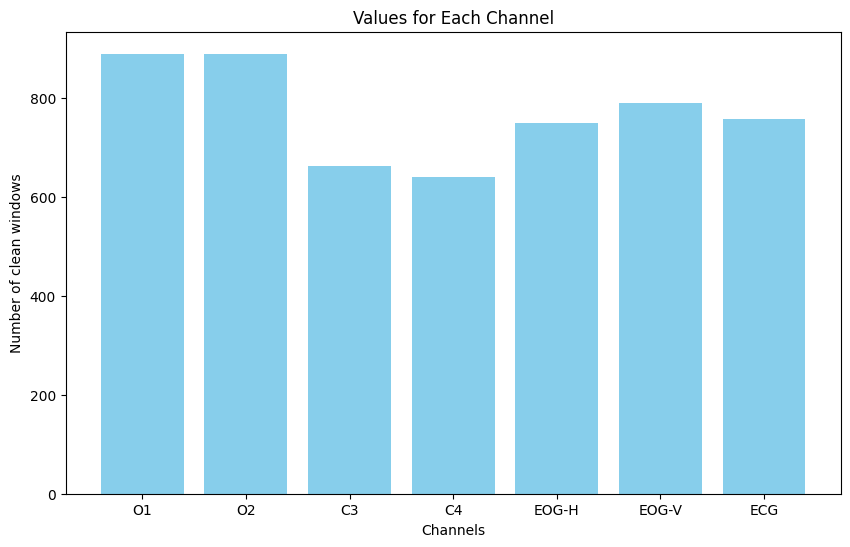

In [23]:
import matplotlib.pyplot as plt

# Data
labels = ['O1', 'O2', 'C3', 'C4', 'EOG-H', 'EOG-V', 'ECG']
values = [890, 890, 662, 640, 750, 790, 758]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Channels')
plt.ylabel('Number of clean windows')
plt.title('Values for Each Channel')
plt.show()


### Nothing, original data

In [7]:
X_resample = {}
Y_resample = {}

for merge in new_classes:
    X_resample[merge] = X
    Y_resample[merge] = new_classes[merge]['labels']

## 1. Feature Selection using RFE with RandomForest


In [8]:
from sklearn.feature_selection import RFE

X_rfe = {}
for merge in new_classes:
    X_merge = X_resample[merge]
    Y_merge = Y_resample[merge]

    rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)
    X_rfe[merge] = rfe.fit_transform(X_merge, Y_merge)


## 2. Further Feature Selection using Feature Importance from RandomForest

In [9]:
X_selected = {}

for merge in new_classes:
    X_merge = X_rfe[merge]
    Y_merge = Y_resample[merge]
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_merge, Y_merge)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    selected_indices = indices[:10]  # Select top 10 features

    X_selected[merge] = X_merge[:, selected_indices]

## 3. Dimensionality Reduction using LDA

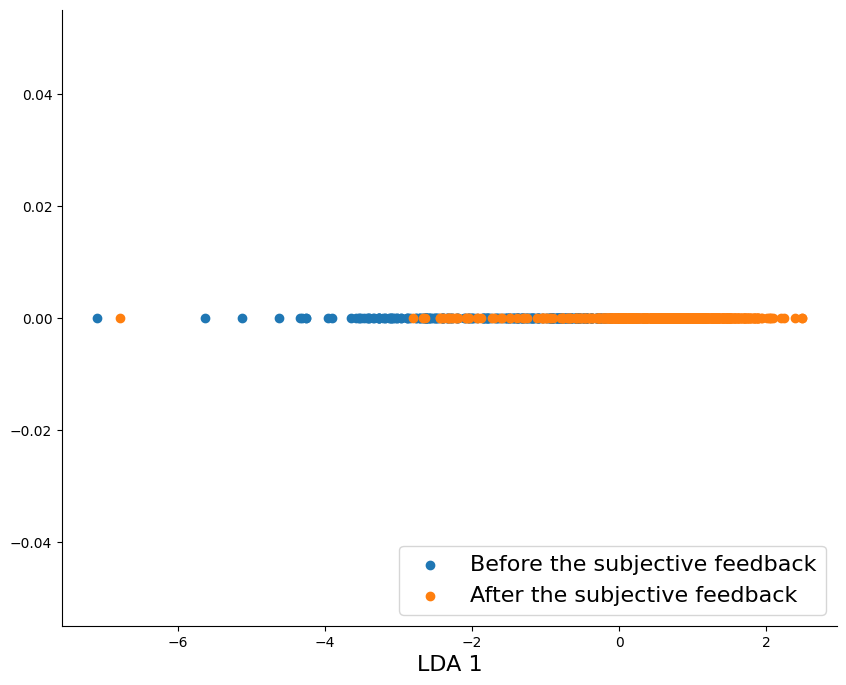

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X_lda = {}
for merge in new_classes:
    X_merge = X_selected[merge]
    Y_merge = Y_resample[merge]
    
    lda = LDA(n_components=1)
    X_lda[merge] = lda.fit_transform(X_merge, Y_merge)
    
    # Plot LDA results
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(Y_merge)
    for i, label in enumerate(unique_labels):
        mask = Y_merge == label
        if i == 0:
            _label = 'Before the subjective feedback'
        else:
            _label = 'After the subjective feedback'

        plt.scatter(X_lda[merge][mask, 0], np.zeros_like(X_lda[merge][mask, 0]), label=f'{_label}')
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.xlabel('LDA 1', fontsize=16)
    plt.legend(loc='lower right', fontsize=16)
    plt.show()


## 4. PCA (Suspend)

In [11]:
# pca_tree = {}

# for merge in new_classes:
#     X_tree_merge = X_tree[merge]
#     Y_merge = Y_resample[merge]
    
#     pca = PCA(n_components=2)
#     pc = pca.fit_transform(X_tree_merge)
#     pca_tree[merge] = pc

#     plt.figure(figsize=(10, 7))
#     scatter = plt.scatter(pc[:, 1], pc[:, 0], c=Y_merge, cmap='viridis', alpha=0.6)
#     plt.title('PCA - Results from Decision Tree')
#     plt.xlabel('2nd Principal component')
#     plt.ylabel('1st Principal component')
#     plt.legend(*scatter.legend_elements(), title="Dizziness Level")
#     plt.show()

### Training and testimg

In [12]:
import seaborn as sns


######### 2 levels #########
###################### SVM - 2 levels ####################
Average Accuracy: 0.8789460020768433
Average Precision: 0.8507010037392091
Average Recall: 0.8816673644338119
Class 1 - Precision: 0.7529273504273504, Recall: 0.8883522727272727, F1-Score: 0.8145929141201286
Class 2 - Precision: 0.9484746570510678, Recall: 0.8749824561403509, F1-Score: 0.9100996906704439
###################### k-NN - 2 levels ####################
Average Accuracy: 0.866839736933195
Average Precision: 0.839671699328018
Average Recall: 0.8499194577352472
Class 1 - Precision: 0.7631411493433989, Recall: 0.8075757575757576, F1-Score: 0.7834520486473816
Class 2 - Precision: 0.916202249312637, Recall: 0.8922631578947369, F1-Score: 0.9037572744521821
###################### Random Forest - 2 levels ####################
Average Accuracy: 0.8221356870889581
Average Precision: 0.7899775835513074
Average Recall: 0.786880980861244
Class 1 - Precision: 0.7077039867807386, Recall: 0.69867424242424

C:\Users\Nhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


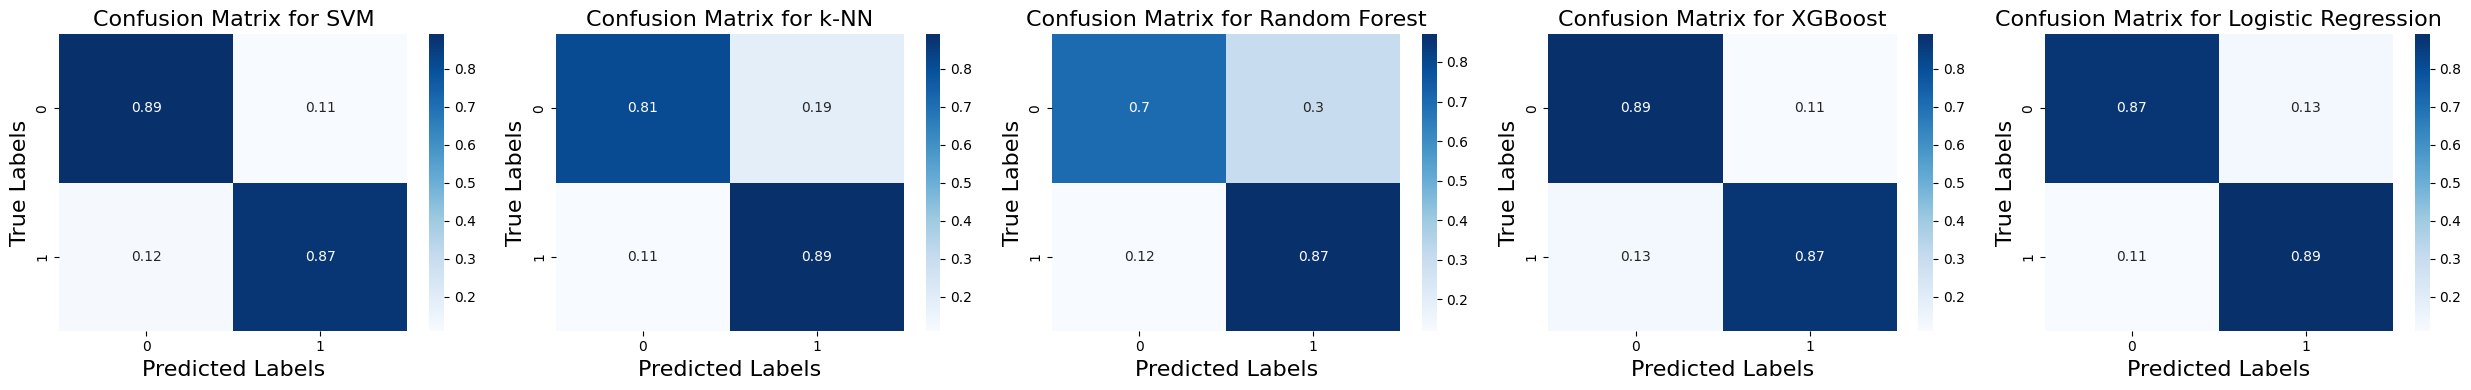

#########################################################



In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

k = 10
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# from sklearn.model_selection import LeaveOneOut
# loo = LeaveOneOut()

for merge in X_lda:
    print(f'######### {merge} #########')
    Y_merge = Y_resample[merge]
    X_merge = X_lda[merge]

    # Ensure labels are transformed to start from 0
    # label_encoder = LabelEncoder()
    # Y_merge = label_encoder.fit_transform(Y_merge)

    models = {
        'SVM': SVC(kernel='rbf', class_weight='balanced'),
        # 'Decision Tree': DecisionTreeClassifier(random_state=42, criterion='log_loss', class_weight='balanced'),
        'k-NN': KNeighborsClassifier(n_neighbors=5),

        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy', class_weight='balanced'),
        'XGBoost': xgb.XGBClassifier(objective='multi:softprob', max_depth=3, n_estimators=100, learning_rate=0.1, eval_metric='mlogloss', use_label_encoder=False, seed=42),
        'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
    }


    unique, counts = np.unique(Y_merge, return_counts=True)

    model_results = {name: {'Accuracy': [], 
                            'Precision': [], 
                            'Recall': [], 
                            'Confusion Matrix': [], 
                            'Class Metrics': {str(i): {'Precision': [], 'Recall': [], 'F1-Score': []} for i in unique}
    } for name in models.keys()}

    # Perform stratified k-fold cross-validation
    for train_index, test_index in kf.split(X_merge, Y_merge):
    # for train_index, test_index in loo.split(X_merge, Y_merge):
        for name, model in models.items():
            X_train, X_test = X_merge[train_index], X_merge[test_index]
            Y_train, Y_test = Y_merge[train_index], Y_merge[test_index]
            
            if name == 'XGBoost':
                Y_train = Y_train - 1
                Y_test = Y_test - 1
                # label_encoder = LabelEncoder()
                # Y_train = label_encoder.fit_transform(Y_train)
                # Y_test = label_encoder.fit_transform(Y_test)
                # xgb_param = model.get_xgb_params()
                # xgb_param['num_class'] = 2
                model.set_params(num_class=2)

                sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train)
                model.fit(X_train, Y_train, sample_weight=sample_weights, eval_set=[(X_test, Y_test)], verbose=False)
                Y_pred = model.predict(X_test)
                                # Convert probabilities to class labels
                if Y_pred.ndim > 1:
                    Y_pred = np.argmax(Y_pred, axis=1)
            else:
                model.fit(X_train, Y_train)
                Y_pred = model.predict(X_test)

            
            # print("Y_test: ", Y_test)
            # print("y_pred: ", Y_pred)

            accuracy = accuracy_score(Y_test, Y_pred)
            conf_matrix = confusion_matrix(Y_test, Y_pred)
            report = classification_report(Y_test, Y_pred, output_dict=True)

            model_results[name]['Accuracy'].append(accuracy)
            model_results[name]['Precision'].append(report['macro avg']['precision'])
            model_results[name]['Recall'].append(report['macro avg']['recall'])
            model_results[name]['Confusion Matrix'].append(conf_matrix)
            
            # Store class-specific metrics for each class
            for cl in unique:  # Adjust 'number_of_classes' as needed
                if str(cl) in report:
                    model_results[name]['Class Metrics'][str(cl)]['Precision'].append(report[str(cl)]['precision'])
                    model_results[name]['Class Metrics'][str(cl)]['Recall'].append(report[str(cl)]['recall'])
                    model_results[name]['Class Metrics'][str(cl)]['F1-Score'].append(report[str(cl)]['f1-score'])

            # # Store the performance of the models for the visualization later
            # new_classes[merge]['accuracy'].append(accuracy)
            # _precision, _recall, _f1_score = extract_average_metrics(report)
            # new_classes[merge]['precision'].append(_precision)
            # new_classes[merge]['recall'].append(_recall)

    fig, axes = plt.subplots(1, 5, figsize=(25, 4))  # Adjust the figure size as needed

    # Iterate through each model and their results
    for idx, (model_name, metrics) in enumerate(model_results.items()):
        print(f"###################### {model_name} - {merge} ####################")
        print("Average Accuracy:", np.mean(metrics['Accuracy']))
        print("Average Precision:", np.mean(metrics['Precision']))
        print("Average Recall:", np.mean(metrics['Recall']))
        
        # Calculate and print average class-specific metrics
        for cl, cls_metrics in metrics['Class Metrics'].items():
            avg_precision = np.mean(cls_metrics['Precision'])
            avg_recall = np.mean(cls_metrics['Recall'])
            avg_f1_score = np.mean(cls_metrics['F1-Score'])
            print(f"Class {cl} - Precision: {avg_precision}, Recall: {avg_recall}, F1-Score: {avg_f1_score}")
            
            new_classes[merge]['Class Metrics'][str(cl)]['Precision'].append(avg_precision)
            new_classes[merge]['Class Metrics'][str(cl)]['Recall'].append(avg_recall)
            new_classes[merge]['Class Metrics'][str(cl)]['F1-Score'].append(avg_f1_score)

        # Store the performance of the models for the visualization later
        new_classes[merge]['accuracy'].append(np.mean(metrics['Accuracy']))
        new_classes[merge]['precision'].append(np.mean(metrics['Precision']))
        new_classes[merge]['recall'].append(np.mean(metrics['Recall']))
        
        # Calculate the average confusion matrix
        mean_conf_matrix = np.mean(metrics['Confusion Matrix'], axis=0)
        
        row_sums = mean_conf_matrix.sum(axis=1, keepdims=True)
        norm_conf_matrix = mean_conf_matrix / row_sums
        norm_conf_matrix = np.round(norm_conf_matrix, 2)

        # Plot the confusion matrix using seaborn on the respective subplot axis
        sns.heatmap(norm_conf_matrix, annot=True, fmt='g', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'Confusion Matrix for {model_name}', fontsize=16)
        axes[idx].set_xlabel('Predicted Labels', fontsize=16)
        axes[idx].set_ylabel('True Labels', fontsize=16)


    # Adjust the layout so labels do not overlap
    plt.tight_layout()
    plt.show()

    print("#########################################################\n")

In [14]:
# from sklearn.inspection import DecisionBoundaryDisplay

# # Plot decision boundary
# plt.figure(figsize=(20, 20))
# DecisionBoundaryDisplay.from_estimator(
#     svm_model, X_lda, cmap=plt.cm.coolwarm, alpha=0.5,
#     response_method="predict",
#     plot_method="pcolormesh",
#     shading='auto'
# )
# plt.scatter(X_lda[:, 0], X_lda[:, 1], c=Y, edgecolors='k', alpha=0.6, cmap='viridis')
# plt.title('SVM Decision Boundary - Weights - 5 classes')
# plt.show()

## Visualize

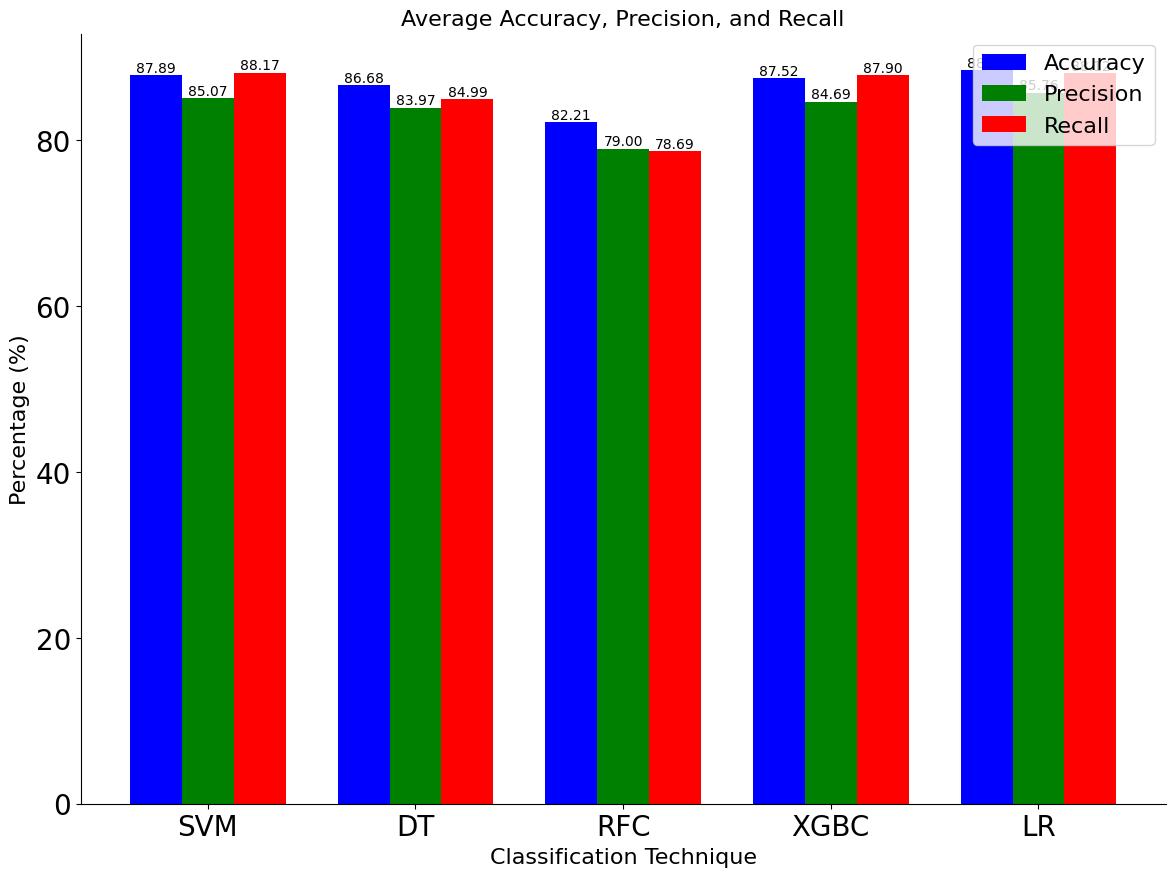

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')


# Set up the bar widths and positions
bar_width = 0.3
index = np.arange(5)

classes_plot = {
    '2 levels': {
        'bar-index': index + 2 * bar_width,
        'color': 'b'
    }
}

# Set up the bar widths and positions
bar_width = 0.25
index = np.arange(5)

classes_plot = {
    'accuracy': {
        'bar-index': index,
        'color': 'b',
        'label': 'Accuracy'
    },
    'precision': {
        'bar-index': index + bar_width,
        'color': 'g',
        'label': 'Precision'
    },
    'recall': {
        'bar-index': index + 2 * bar_width,
        'color': 'r',
        'label': 'Recall'
    }
}

plt.figure(figsize=(14, 10))

# Plot Accuracy, Precision, and Recall on the same plot
for metric in ['accuracy', 'precision', 'recall']:
    metric_values = np.array(new_classes['2 levels'][metric]) * 100
    bar_indices = classes_plot[metric]['bar-index']
    bar = plt.bar(bar_indices, metric_values, bar_width, label=classes_plot[metric]['label'], color=classes_plot[metric]['color'])
    add_labels(bar)

plt.xlabel('Classification Technique', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=16)
plt.title('Average Accuracy, Precision, and Recall', fontsize=16)
plt.xticks(index + bar_width, ('SVM', 'DT', 'RFC', 'XGBC', 'LR'), fontsize=16)
plt.legend(loc='upper right', fontsize=16)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='both', labelsize=20)

plt.show()

### CDF